# **import**

In [1]:
import json
import os
import re
import warnings
from multiprocessing import Pool, cpu_count
from typing import Union, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# from google.colab import drive
from konlpy.tag import Okt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold
from soynlp.normalizer import repeat_normalize
from tensorflow.keras import layers, callbacks, optimizers, activations
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tokenizers import BertWordPieceTokenizer
from tqdm.notebook import tqdm

# drive.mount('/content/drive')
warnings.filterwarnings(action='ignore')

tf.get_logger().setLevel('ERROR') 
tf.autograph.set_verbosity(3)

ModuleNotFoundError: No module named 'konlpy'

# **데이터**

## utils

In [2]:
def filtering(text, okt):
    def check_typo(text):
        if re.match('[ㄱ-ㅎ]+', text):
            text_set = set(text)
            if len({'ㅋ', 'ㅌ', 'ㄴ'} - text_set) < 2:
                text = 'ㅋ' * len(text)

            elif {'ㅎ', 'ㄹ'} == text_set:
                text = 'ㅎ' * len(text)

        return text
        
    text = okt.normalize(text.lower())
    text = check_typo(text)
    text = re.sub(r' {2,}', ' ', text)
    text = re.sub(r'[^ .,?!%~\^\[\]\-_가-힣ㄱ-ㅎㅏ-ㅣa-z0-9]+|http.+|(?<=\d),(?=\d)', '', text)
    
    text = repeat_normalize(text, 5)
    # text = re.sub(r'(.+?)\1+', r'\1', text)
    text = re.sub(r'(.{3,}?)\1+', r'\1', text)
    return text


path = 'data/raw_data'
talk_data_list = sorted([f for f in os.listdir(path) if f.endswith('.csv')])

okt = Okt()
names = ['승우', '남승우', '세연', '이세연', '이세', '연진', '최연진', '정민', '최정민', '명준', '차명준', '준표', '이준표', '다빈', '최다빈', '희정', '유희정',
         '규리', '김규리', '큐리', '나연', '김나연', '배영', '공배영', '하림', '서하림', '화준', '세영', '오세영', '의현', '이의현', '익현', '우진', '손우진',
         '지웅', '김지웅', '찌찌웅', '찌웅', '지원', '정지원']
names = '|'.join(names)

utterance_size = 4

## 토커나이저

In [4]:
# limit_alphabet = int(input("limit_alphabet: "))
# vocab_size = int(input("vocab_size: "))
limit_alphabet = 6000
vocab_size = 8000

filepath = f'tokenizer/vocab_{limit_alphabet}_{vocab_size}-vocab.txt'
load = input('file load? (y or n): ').lower() == 'y'
# load = True

if os.path.isfile(filepath) and load:
    tokenizer = BertWordPieceTokenizer(vocab_file=filepath)
    df_list = [None for filename in talk_data_list]

else:
    df_list = [pd.read_csv(f"{path}/{filename}", encoding="utf-8") for filename in talk_data_list]
    all_df = pd.concat(df_list)

    all_df.dropna(inplace=True)
    all_df.reset_index(inplace=True, drop=True)
    all_df['contents'] = all_df['contents'].apply(lambda x: filtering(x, okt))
    all_df['contents'] = all_df['contents'].str.replace(names, '[NAME]')
    # all_df = all_df[all_df['contents'].str.len() >= 5]
    all_df = all_df[(all_df['contents'].str.len() < 70) & (all_df['contents'].str.len() >= 5)]

    with open('tokenizer/tokenizer_train_data.txt', 'w', encoding='utf-8') as f:
        for line in all_df['contents']:
            f.write(line + '\n')

    tokenizer = BertWordPieceTokenizer(
        clean_text=True,
        handle_chinese_chars=True,
        strip_accents=False, # Must be False if cased model
        lowercase=False,
        wordpieces_prefix="##", 
    )
    special_tokens = [
                      '[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '[SEPT]', '[NAME]',
                      '[BOS]', '[EOS]', '[UNK0]', '[UNK1]', '[UNK2]', '[UNK3]', '[UNK4]', '[UNK5]', '[UNK6]', '[UNK7]', '[UNK8]', '[UNK9]',
    ] + [f'[unused{i}]' for i in range(100)]

    print('train')
    tokenizer.train(
        files=['tokenizer/tokenizer_train_data.txt'],
        limit_alphabet=limit_alphabet,
        vocab_size=vocab_size, 
        special_tokens=special_tokens,
    )

    tokenizer.save("tokenizer", f"vocab_{limit_alphabet}_{vocab_size}")

file load? (y or n): y


## 전처리

In [5]:
def preprocessing(df):
    df = df.dropna()
    df = df.drop(df[df['contents'].str.startswith('삭제된 메시지입니다.')].index)
    df = df.drop(df[df['contents'].str.startswith('파일:')].index)

    # for s in '이모티콘\n사진\n동영상'.split('\n'):
    #     df = df[df['contents'] != s]

    df['writer'] = df['writer'].apply(lambda x: 0 if x == '남승우' else 1)
    df['contents_original'] = df['contents']
    df['contents'] = df['contents'].str.replace(r'사진 \d+장', '사진')
    df['contents'] = df['contents'].str.replace(r'^이모티콘 (?=\w+)', '')
    df['contents'] = df['contents'].apply(lambda x: filtering(x, okt))
    df['contents'] = df['contents'].str.replace(names, '[NAME]')
    df = df[df['contents'].str.len() >= 5]
    df.reset_index(inplace=True, drop=True)
    df['ids'] = df['contents'].apply(lambda x: tokenizer.encode(x).ids)

    return df
    

def save_data(params):
    assert len(params) == 4, 'params must be 4.'
    df, utterance_size, filename, load = params

    if load and (False if filename is None else os.path.isfile(filename)):
        print(filename + ' load\n', end='')

        data = pd.read_csv(filename, encoding='utf-8')
        for column in data.columns[:-1]:
            data[column] = data[column].apply(lambda x: list(map(int, x[1:-1].split(', '))))
    
    else:
        print(filename + ' preprocessing\n', end='')
        data = pd.DataFrame(columns=[f'utterance_{i+1}' for i in range(utterance_size)] + ['label', 'original'])
        # data = pd.DataFrame(columns=[f'utterance_{i+1}' for i in range(utterance_size)] + ['label', 'original', 'filtered'])
    
        initial_content = [2]
        temp_dict = {
            'content': initial_content.copy(), 
            'last_original': '',
            'writer': None,
            'utterances': [initial_content.copy() for _ in range(utterance_size + 1)]
        }
        for i in tqdm(range(len(df))):
        # for i in range(len(df)):
            row = df.iloc[i]
            if temp_dict['writer'] != row['writer'] and temp_dict['content'] != initial_content:  # 발화자가 다를때 비어있지 않으면
                temp_dict['content'].append(5)  # [SEPT] 추가
                temp_dict['utterances'].append(temp_dict['content'])
                temp_dict['utterances'] = temp_dict['utterances'][1:]

                line = temp_dict['utterances'] + [temp_dict['last_original']]
                data = data.append(pd.Series(line, index=data.columns), ignore_index=True)  # 추가

                temp_dict['content'] = initial_content.copy()
                temp_dict['last_original'] = ''
            
            temp_dict['content'] += row['ids'] + [3]  # [SEP] 추가
#             temp_dict['last_original'] += row['contents_original'] + ' [SEP] '
            temp_dict['last_original'] += row['contents_original']
            temp_dict['writer'] = row['writer']

            # utterances = df.iloc[i: i + utterance_size]['ids'].to_list()
            # label = df.iloc[i + utterance_size]['ids']
            # original = df.iloc[i + utterance_size]['contents_original']
            # filtered = df.iloc[i + utterance_size]['contents']

            # line = utterances + [label, original, filtered]
            # data = data.append(pd.Series(line, index=data.columns), ignore_index=True)
        temp_dict['utterances'].append(temp_dict['content'])
        temp_dict['utterances'] = temp_dict['utterances'][1:]
        line = temp_dict['utterances'] + [temp_dict['last_original']]
        data = data.append(pd.Series(line, index=data.columns), ignore_index=True)  # 추가

        if filename:
            data.to_csv(filename, encoding='utf-8', index=None)

    return data

In [6]:
preprocessed_data_fnames = [f'data/preprocessed_data/{f}' for f in talk_data_list]

load = input('file load? (y or n): ').lower() == 'y'
print(load)
# load = True

df_list = [None if load else preprocessing(df) for df in tqdm(df_list)]
print('prepocessing Done!')

with Pool(cpu_count()) as p:
    datas = p.map(save_data, [(df, utterance_size, fname, load) for df, fname in zip(df_list, preprocessed_data_fnames)])

file load? (y or n): y
True



prepocessing Done!
data/preprocessed_data/a 남승우 공배영.csv load
data/preprocessed_data/a 남승우 서하림.csv load
data/preprocessed_data/a 남승우 세연.csv load
data/preprocessed_data/a 남승우 연진.csv load
data/preprocessed_data/i 냄승 준표.csv load
data/preprocessed_data/a 남승우 짱친정민.csv load
data/preprocessed_data/a 남승우(개새끼) 차명준.csv load
data/preprocessed_data/w Scaredy-cat 규리.csv load
data/preprocessed_data/w 남승우 오세영.csv load
data/preprocessed_data/w 남승우 GSM 김나연.csv load
data/preprocessed_data/i 인지부장 최다빈.csv load
data/preprocessed_data/w 키작남슝😜 손우진.csv load
data/preprocessed_data/w 남승우 찌찌웅.csv load
data/preprocessed_data/w 남승우 이의현.csv load
data/preprocessed_data/i 청멍청멍 희정.csv load
data/preprocessed_data/w 남승우 정지원.csv load


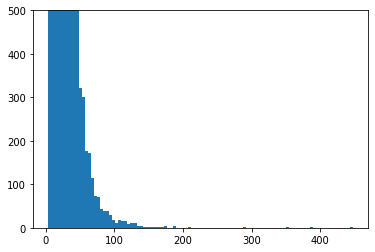

In [7]:
data = pd.concat(datas)
data.reset_index(inplace=True, drop=True)

max_len = 100

data['lens'] = [len(l) for l in data['label'].to_list()]

plt.hist(data['lens'], max_len)
plt.ylim(0, 500)
# plt.xlim(0, 500)
# plt.boxplot(lens_of_data)
plt.show()

In [8]:
fname = 'data/preprocessed_data/data.csv'

def data_func(param):
    cpu_n, data = param
    new_data = pd.DataFrame(columns=[f'context_{i+1}' for i in range(utterance_size)] + ['response', 'y'])
    print(f'cpu_n: {cpu_n}')

    for i in tqdm(range(len(data))):
        row = data.iloc[i]
        contexts = row[:4].to_list()
        response = row[4][:-1]
        y = row[4][1:]
        line = contexts + [response, y]
        new_data = new_data.append(pd.Series(line, index=new_data.columns), ignore_index=True)
        # for j in range(1, len(response)):
        #     line = contexts + [response[:j], response[j]]
        #     new_data = new_data.append(pd.Series(line, index=new_data.columns), ignore_index=True)
    
    return new_data


if os.path.isfile(fname) and input('file load?: (y or n): ') == 'y':
    print('load')
    new_data = pd.read_csv(fname, encoding='utf-8')
    for column in new_data.columns:
    for column in new_data.columns[:-1]:
        new_data[column] = new_data[column].apply(lambda x: list(map(int, x[1:-1].split(', '))))
    
else:
    print('save')
    split_n = len(data) / cpu_count()
    print('core count:', split_n)

    # new_data = data_func((0, data))
    with Pool(cpu_count()) as p:
        new_data = p.map(data_func, [(i+1, data.iloc[int(i * split_n): int((i+1) * split_n)]) for i in range(cpu_count())])

    new_data = pd.concat(new_data)
    new_data.reset_index(inplace=True, drop=True)
    new_data.to_csv(fname, encoding='utf-8', index=None)


print(new_data.shape)
new_data.head()

file load?: (y or n): y
load
(1098288, 6)


,context_1,context_2,context_3,context_4,response,y
0,[2],[2],[2],[2],[2],539
1,[2],[2],[2],[2],"[2, 539]",6456
2,[2],[2],[2],[2],"[2, 539, 6456]",5469
3,[2],[2],[2],[2],"[2, 539, 6456, 5469]",6406
4,[2],[2],[2],[2],"[2, 539, 6456, 5469, 6406]",2950


In [9]:
context = np.transpose([pad_sequences(new_data[col].to_list(), max_len, truncating="post", padding="post") for col in new_data.columns[:utterance_size]], axes=[1, 0, 2])
response = pad_sequences(new_data['response'].to_list(), max_len, truncating="post", padding="post")
y = pad_sequences(new_data['y'].to_list(), max_len, truncating="post", padding="post")
# context = np.transpose([pad_sequences(new_data[col].to_list(), max_len) for col in new_data.columns[:utterance_size]], axes=[1, 0, 2])
# response = pad_sequences(new_data['response'].to_list(), max_len)
# y = new_data['y'].to_numpy(dtype=np.int32)

context_train, context_test, y_train, y_test = train_test_split(context, y, test_size=0.1, random_state=1)
response_train, response_test, y_train, y_test = train_test_split(response, y, test_size=0.1, random_state=1)

# class_weight = dict(enumerate(compute_class_weight('balanced', np.unique(y), y)))
# class_weight = {
#     i: class_weight.get(i, 0)
#     for i in range(vocab_size)
# }

context_train.shape, context_test.shape, response_train.shape, response_test.shape, y_train.shape, y_test.shape

((988459, 4, 100),
 (109829, 4, 100),
 (988459, 100),
 (109829, 100),
 (988459,),
 (109829,))

# **모델링**

In [10]:
def get_shape(x):
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

def gelu(x):
    cdf = 0.5 * (1.0 + tf.math.erf(x / tf.math.sqrt(2.0)))
    return x * cdf

## 임베딩 레이어

In [11]:
class Embedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_size, max_len, dropout_rate=0.2):
        super().__init__()

        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.max_len = max_len
        self.dropout_rate = dropout_rate

        self.position_embedding = self.positional_encoding(self.max_len)

        self.word_embedding = self.add_weight(
            "weight",
            shape=(self.vocab_size, self.embedding_size),
            initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
        )

        self.normalize = tf.keras.layers.LayerNormalization()
        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)

    def get_angles(self, pos, i):
        angle_rates = 1 / np.power(
            10000, (2 * (i // 2)) / np.float32(self.embedding_size)
        )
        return pos * angle_rates

    def positional_encoding(self, max_len):
        angle_rads = self.get_angles(
            np.arange(max_len)[:, np.newaxis],
            np.arange(self.embedding_size)[np.newaxis, :],
        )

        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, input_ids, token_type_ids=None):
        word_embedding = tf.gather(self.word_embedding, input_ids)
        if token_type_ids is None:
            segment_embedding = tf.fill(get_shape(word_embedding), 0.0)
        else:
            segment_embedding = tf.repeat(
                tf.cast(token_type_ids, dtype=word_embedding.dtype)[:, :, tf.newaxis],
                self.embedding_size,
                axis=-1,
            )

        embedding = word_embedding + self.position_embedding + segment_embedding
        embedding = self.normalize(embedding)
        embedding = self.dropout(embedding)

        return embedding

    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embedding_size": self.embedding_size,
                "max_len": self.max_len,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

## 셀프 어텐션

In [12]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(
        self, num_attention_heads: int, hidden_size: int, dropout_rate: float = 0.2
    ):
        super().__init__()

        assert (
            hidden_size % num_attention_heads == 0
        ), f"hidden_size: {hidden_size}, num_attention_heads: {num_attention_heads}"
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.dropout_rate = dropout_rate

        param_size = self.num_attention_heads * self.attention_head_size
        self.query = tf.keras.layers.Dense(
            param_size,
            kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
            name="query",
        )
        self.key = tf.keras.layers.Dense(
            param_size,
            kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
            name="key",
        )
        self.value = tf.keras.layers.Dense(
            param_size,
            kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
            name="value",
        )
        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)

    def transpose_for_scores(self, x, batch_size):
        x = tf.reshape(
            x, (batch_size, -1, self.num_attention_heads, self.attention_head_size)
        )
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k=None, v=None, attention_mask=None, training=False):
        q = q
        k = q if k is None else k
        v = q if v is None else v

        batch_size = get_shape(q)[0]
        query = self.transpose_for_scores(self.query(q), batch_size)
        key = self.transpose_for_scores(self.key(k), batch_size)
        value = self.transpose_for_scores(self.value(v), batch_size)

        # scaled dot attention
        x = tf.matmul(query, key, transpose_b=True)
        dk = tf.cast(get_shape(key)[-1], x.dtype)
        x /= tf.math.sqrt(dk)

        if attention_mask is not None:
            # attention_mask = self.transpose_for_scores(attention_mask, batch_size)
            x *= attention_mask

        attention_weights = tf.nn.softmax(x, axis=-1)
        attention_weights = self.dropout(attention_weights, training=training)

        context = tf.matmul(attention_weights, value)
        context = tf.transpose(context, perm=[0, 2, 1, 3])
        context = tf.reshape(
            context,
            (batch_size, -1, self.num_attention_heads * self.attention_head_size),
        )

        return context, attention_weights

    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "num_attention_heads": self.num_attention_heads,
                "attention_head_size": self.attention_head_size,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

## 어텐션

In [13]:
class Attention(tf.keras.layers.Layer):
    def __init__(
        self,
        hidden_size: int,
        num_attention_heads: int,
        dropout_rate: float = 0.2,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads
        self.dropout_rate = dropout_rate

        # Attention
        self.selfattention = SelfAttention(num_attention_heads, hidden_size)
        self.dense = tf.keras.layers.Dense(
            self.hidden_size,
            kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
        )
        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)
        self.layernormal = tf.keras.layers.LayerNormalization()

        # Intermediate
        self.intermediate = tf.keras.layers.Dense(
            hidden_size,
            kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
        )

        # output
        self.output_dense = tf.keras.layers.Dense(
            hidden_size,
            kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
        )

    def call(self, input_ids, attention_mask=None, training=False):
        attention_outputs = self.selfattention(
            input_ids, attention_mask=attention_mask, training=training
        )
        x = self.dense(attention_outputs[0])
        x = self.dropout(x, training=training)
        x = self.layernormal(x + input_ids)

        intermediate_output = self.intermediate(x)
        intermediate_output = tf.keras.layers.Activation(gelu)(intermediate_output)

        x = self.output_dense(intermediate_output)
        x = self.dropout(x, training=training)
        x = self.layernormal(x + attention_outputs[0])

        return (x, attention_outputs[1])

    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "num_attention_heads": self.num_attention_heads,
                "hidden_size": self.hidden_size,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

## 메인 모델

In [14]:
class DialogWithAuxility(tf.keras.Model):
    def __init__(
        self,
        vocab_size: int,
        max_len: int,
        utterance_size: int,
        embedding_size: int,
        hidden_size: int,
        attention_head: int,
        encoder_block: int,
        dropout_rate: float,
        FFNN_size: int,
        **kwargs,
    ):
        super(DialogWithAuxility, self).__init__(**kwargs)

        self.vocab_size = vocab_size
        self.max_len = max_len
        self.utterance_size = utterance_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.attention_head = attention_head
        self.encoder_block = encoder_block
        self.dropout_rate = dropout_rate
        self.FFNN_size = FFNN_size

        self.embedding = Embedding(self.vocab_size, self.embedding_size, self.max_len)
        self.dense = tf.keras.layers.Dense(self.hidden_size, use_bias=False)
        self.attention_blocks = [
            Attention(
                self.hidden_size,
                self.attention_head,
                self.dropout_rate,
                name=f"attention_block_{i+1}",
            )
            for i in range(self.encoder_block)
        ]
        self.set_attention_mask = tf.keras.layers.Lambda(
            lambda x: tf.dtypes.cast((x > 1), tf.float32)
        )
        self.decoder_attention = SelfAttention(self.attention_head, self.hidden_size)

        self.concat = tf.keras.layers.Concatenate(axis=1)

        self.FFNN = Sequential(
            layers=[
                tf.keras.layers.Dense(self.FFNN_size, activation="linear"),
                tf.keras.layers.Dropout(self.dropout_rate),
                tf.keras.layers.BatchNormalization(),
            ],
            name="FFNN",
        )
        self.output_layer = tf.keras.layers.Dense(
            self.vocab_size, use_bias=False, activation="softmax"
        )

    def call_blocks(self, Input, blocks, mask=None, training=False):
        if mask is None:
            mask = tf.fill(get_shape(Input)[:-1], 1.0)
        mask = (1.0 - mask[:, tf.newaxis, tf.newaxis, :]) * -10000.0

        result = None
        for i, layer in enumerate(blocks):
            if result is None:
                result, hidden_state = layer(Input, mask, training=training)

            else:
                result, hidden_state = layer(result, training=training)

        return (result, hidden_state)

    def call_encoder(self, input_ids, token_type_ids, attention_blocks, training=False):
        embedding = self.embedding(input_ids, token_type_ids)
        embedding = self.dense(embedding)
        masks = self.set_attention_mask(input_ids)
        output = self.call_blocks(embedding, attention_blocks, masks, training=training)

        return output

    def call_word_order_recovery(
        self, suffled_idx, input_contexts, token_type_ids=None, training=False
    ):
        encoder_output = [
            self.call_encoder(
                input_contexts[:, i],
                None if token_type_ids is None else token_type_ids[:, i],
                self.attention_blocks,
                training=training,
            )[0]
            for i in range(self.utterance_size)
        ]
        E = self.concat(encoder_output)
        q = encoder_output[suffled_idx]

        decoder_attention = self.decoder_attention(q, k=E, v=E, training=training)[0]
        ffnn = self.FFNN(decoder_attention)
        output = self.output_layer(ffnn)
        return output

    def call_utterance_order_recovery(
        self, input_contexts, token_type_ids=None, training=False
    ):
        return None

    def call_masked_word_recovery(
        self,
        masked_utterance_idx,
        masked_idxes,
        input_contexts,
        token_type_ids=None,
        training=False,
    ):
        encoder_output = [
            self.call_encoder(
                input_contexts[:, i],
                None if token_type_ids is None else token_type_ids[:, i],
                self.attention_blocks,
                training=training,
            )[0]
            for i in range(self.utterance_size)
        ]
        E = self.concat(encoder_output)
        q = tf.concat(
            [
                encoder_output[masked_utterance_idx][:, tf.newaxis, i, :]
                for i in masked_idxes
            ],
            axis=1,
        )

        decoder_attention = self.decoder_attention(q, k=E, v=E, training=training)[0]
        ffnn = self.FFNN(decoder_attention)
        output = self.output_layer(ffnn)
        return output

    def call_masked_utterance_recovery(
        self, masked_utterance_idx, input_contexts, token_type_ids=None, training=False
    ):
        encoder_output = [
            self.call_encoder(
                input_contexts[:, i],
                None if token_type_ids is None else token_type_ids[:, i],
                self.attention_blocks,
                training=training,
            )[0]
            for i in range(self.utterance_size)
        ]
        E = self.concat(encoder_output)
        q = encoder_output[masked_utterance_idx]

        decoder_attention = self.decoder_attention(q, k=E, v=E, training=training)[0]
        ffnn = self.FFNN(decoder_attention)
        output = self.output_layer(ffnn)
        return output

    def call_auxiliary_tasks(
        self, info_dict: Dict, input_contexts, token_type_ids=None, training=False
    ):
        assert set(info_dict.keys()) == {
            "wor_suffled_idx",
            "mwr_masked_utterance_idx",
            "mwr_masked_idxes",
            "mur_masked_utterance_idx",
        }, "argument is not required."

        return (
            self.call_word_order_recovery(
                suffled_idx=info_dict["wor_suffled_idx"],
                input_contexts=input_contexts,
                token_type_ids=token_type_ids,
                training=training,
            ),
            # self.call_utterance_order_recovery(input_contexts, token_type_ids, training=training),
            self.call_masked_word_recovery(
                masked_utterance_idx=info_dict["mwr_masked_utterance_idx"],
                masked_idxes=info_dict["mwr_masked_idxes"],
                input_contexts=input_contexts,
                token_type_ids=token_type_ids,
                training=training,
            ),
            self.call_masked_utterance_recovery(
                masked_utterance_idx=info_dict["mur_masked_utterance_idx"],
                input_contexts=input_contexts,
                token_type_ids=token_type_ids,
                training=training,
            ),
        )

    def call(self, kw_inputs: Dict):
        kw = kw_inputs.keys()

        # 변수 할당
        assert "input_contexts" in kw, "input_contexts  must require."
        input_contexts = kw_inputs["input_contexts"]
        assert "input_response" in kw, "input_response  must require."
        input_response = kw_inputs["input_response"]

        contexts_token_type_ids = kw_inputs.get("contexts_token_type_ids", None)
        response_token_type_ids = kw_inputs.get("response_token_type_ids", None)
        training = kw_inputs.get("training", False)

        assert (
            len(get_shape(input_contexts)) == 3
        ), f"input ids ndim must be 3, but inputed {input_contexts.ndim} dim tensor."
        assert (
            get_shape(input_contexts)[1] == self.utterance_size
        ), f"A total of {self.utterance_size} utterances must be entered."

        # call
        contexts_encoder_outputs = [
            self.call_encoder(
                input_contexts[:, i],
                None
                if contexts_token_type_ids is None
                else contexts_token_type_ids[:, i],
                self.attention_blocks,
                training=training,
            )[0]
            for i in range(self.utterance_size)
        ]
        response_encoder_output = self.call_encoder(
            input_response,
            response_token_type_ids,
            self.attention_blocks,
            training=training,
        )[0]

        if training:
            decoder_attention = []
            for i in range(1, get_shape(response_encoder_output)[1]):
                E = self.concat(
                    contexts_encoder_outputs + [response_encoder_output[:, :i, :]]
                )

                temp = self.decoder_attention(
                    response_encoder_output[:, i : i + 1, :],
                    k=E,
                    v=E,
                    training=training,
                )[0]
                decoder_attention.append(temp)
            decoder_attention = self.concat(decoder_attention)

        else:
            E = self.concat(
                contexts_encoder_outputs + [response_encoder_output[:, :-1, :]]
            )

            decoder_attention = self.decoder_attention(
                response_encoder_output[:, -1:, :], k=E, v=E, training=training
            )[0]

        decoder_FFNN = self.FFNN(decoder_attention)
        output = self.output_layer(decoder_FFNN)

        return output

    # def _repeats(tensor, repeats, axis):
    #     return repeat(tensor, repeats=repeats, axis=axis)

    def get_config(self):
        config = {
            "vocab_size": self.vocab_size,
            "max_len": self.max_len,
            "utterance_size": self.utterance_size,
            "embedding_size": self.embedding_size,
            "hidden_size": self.hidden_size,
            "attention_head": self.attention_head,
            "encoder_block": self.encoder_block,
            "dropout_rate": self.dropout_rate,
            "FFNN_size": self.FFNN_size,
        }
        return config

# **모델 빌드**

In [22]:
mirrored_strategy = tf.distribute.MirroredStrategy()
# mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

callback = [
            callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True), 
            callbacks.ReduceLROnPlateau(
                 monitor='val_loss',
                 factor=0.2,
                 patience=3
            ),
            callbacks.ModelCheckpoint(
                filepath="model_weight.h5",
                save_best_only=True, 
                save_weights_only=True
            )
]

with mirrored_strategy.scope():
    model = DialogWithAuxility(vocab_size=vocab_size, 
                               max_len=max_len, 
                               utterance_size=utterance_size, 
                               embedding_size=128, 
                               hidden_size=256, 
                               attention_head=4,
                               encoder_block=4,
                               dropout_rate=0.1,
                               FFNN_size=512,
                               )
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=0.001),
                  metrics=['acc'])

    _ = model((tf.random.uniform((1, utterance_size, max_len), maxval=32000, dtype=tf.int32),
               tf.random.uniform((1, max_len), maxval=32000, dtype=tf.int32)))
    
    model.summary()
    
    if input('model load?: (y or n): ') == 'y' and os.path.isfile('model_weight.h5'):
        model.load_weights('model_weight.h5')

Model: "dialog_with_auxility_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  1024256   
_________________________________________________________________
dense_15 (Dense)             multiple                  32768     
_________________________________________________________________
attention_block_1 (Attention multiple                  395264    
_________________________________________________________________
attention_block_2 (Attention multiple                  395264    
_________________________________________________________________
attention_block_3 (Attention multiple                  395264    
_________________________________________________________________
attention_block_4 (Attention multiple                  395264    
_________________________________________________________________
lambda_1 (Lambda)            multiple       

In [17]:
# model.evaluate((context_test, response_test), y_test)
print(y_test[:3])
model.predict((context_test[:3], response_test[:3])).argmax(axis=-1)

[   3 3397 6064]


array([[123],
       [123],
       [123]])

In [21]:
class_weight[123]
tokenizer.id_to_token(123)

'.'

In [ ]:
%%capture output
history = model.fit((context_train, response_train), y_train,
                    batch_size=256,
                    epochs=50,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callback,
#                     class_weight={i: 1 if i != 3 else 0.0001 for i in range(vocab_size)},
                    class_weight=class_weight,
                   )
model.eval((context_test, response_test), y_test, batch_size=256)

In [30]:
output.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

